In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import itertools
import os
from os import path
import json

/tmp/ipykernel_281116/2082772513.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [7]:
#policies = ["ondemand", "conservative", "performance", "schedutil", "powersave", "userspace"]
policies = ["ondemand"]

# total time to run for, in ms
times = [600000]

# diff flink rates
rates = [i for i in range(100,500,100)] #2100 because python excludes last value.

# number of mappers
mappers = [4,8,12,16]
#mappers = [4]

data/imgproc_cores16_frate100_600000_fratetype_predictable_fbuff-1_itr1_ondemanddvfs1_source16_mapper4_sink16_repeat0
data/imgproc_cores16_frate100_600000_fratetype_predictable_fbuff-1_itr1_ondemanddvfs1_source16_mapper8_sink16_repeat0
data/imgproc_cores16_frate100_600000_fratetype_predictable_fbuff-1_itr1_ondemanddvfs1_source16_mapper12_sink16_repeat0
data/imgproc_cores16_frate100_600000_fratetype_predictable_fbuff-1_itr1_ondemanddvfs1_source16_mapper16_sink16_repeat0
data/imgproc_cores16_frate200_600000_fratetype_predictable_fbuff-1_itr1_ondemanddvfs1_source16_mapper4_sink16_repeat0
data/imgproc_cores16_frate200_600000_fratetype_predictable_fbuff-1_itr1_ondemanddvfs1_source16_mapper8_sink16_repeat0
data/imgproc_cores16_frate200_600000_fratetype_predictable_fbuff-1_itr1_ondemanddvfs1_source16_mapper12_sink16_repeat0
data/imgproc_cores16_frate200_600000_fratetype_predictable_fbuff-1_itr1_ondemanddvfs1_source16_mapper16_sink16_repeat0
data/imgproc_cores16_frate300_600000_fratetype_predi

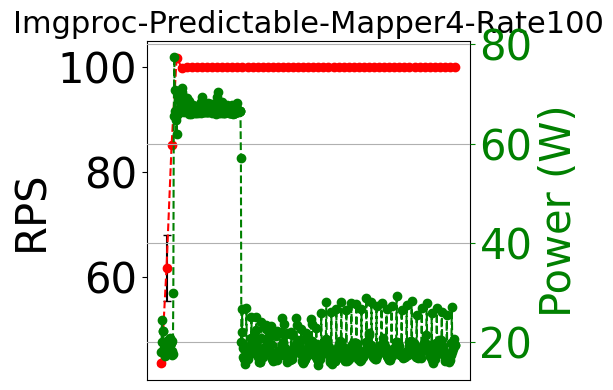

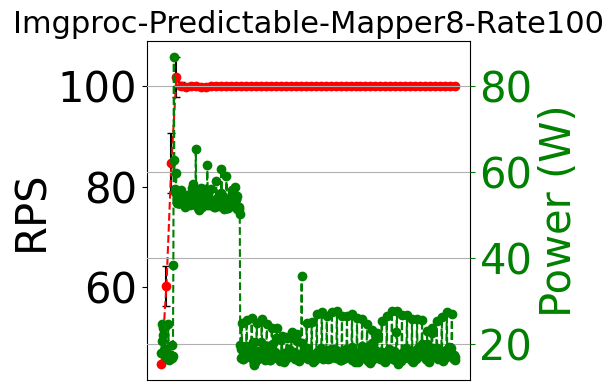

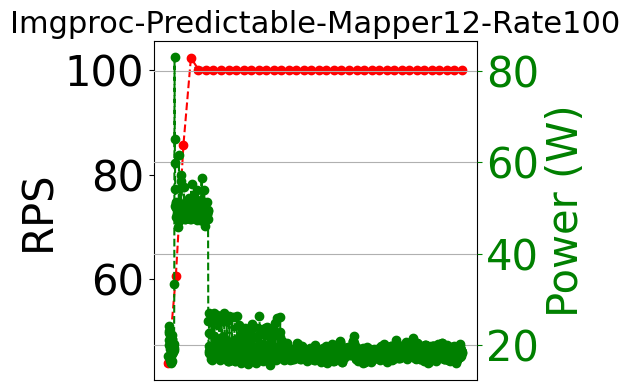

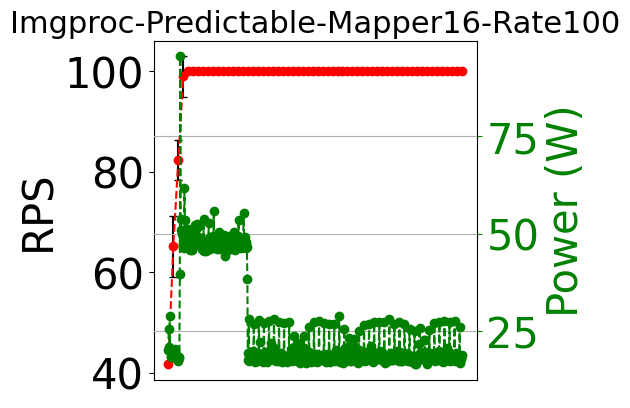

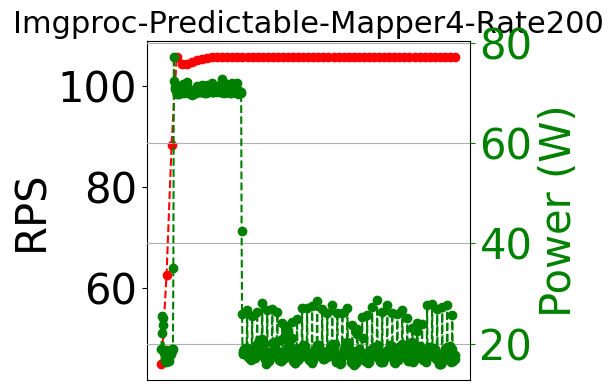

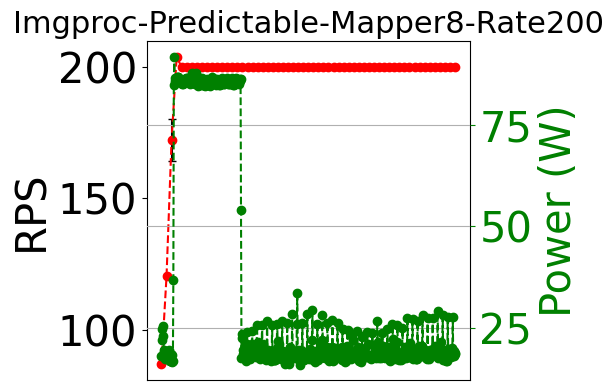

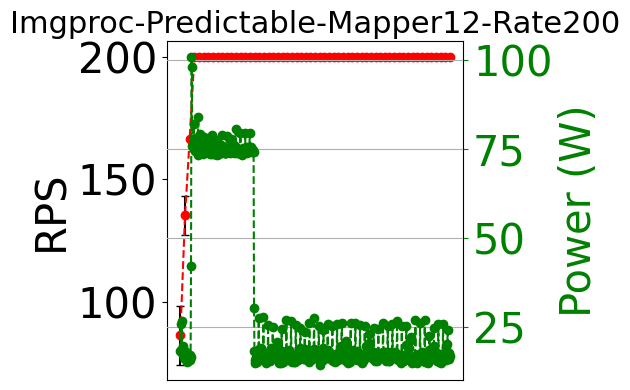

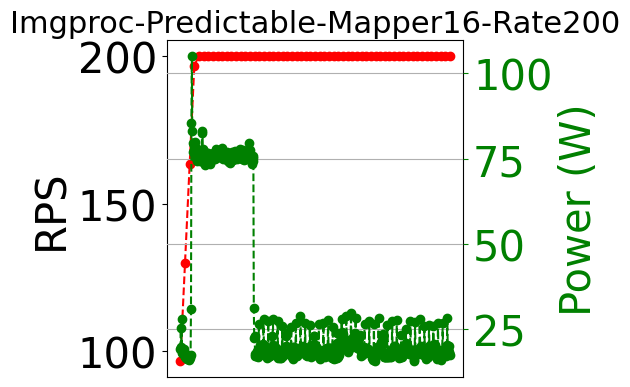

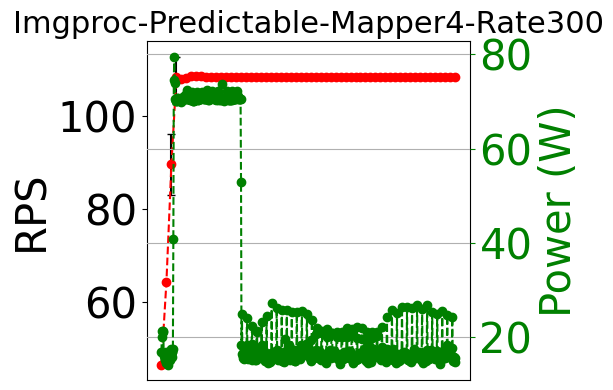

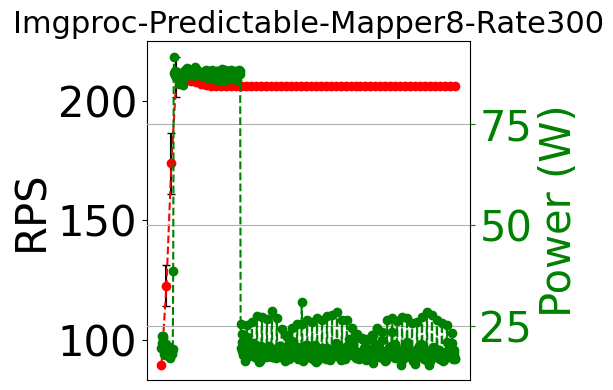

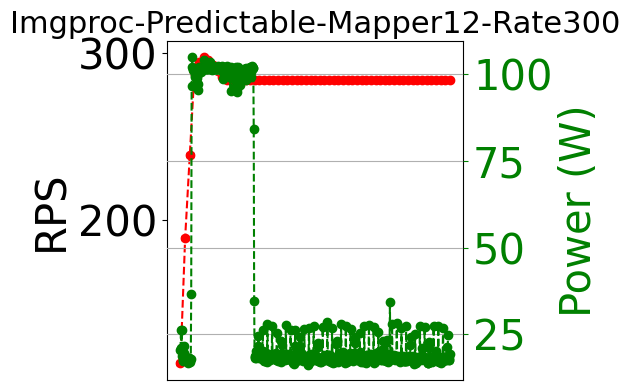

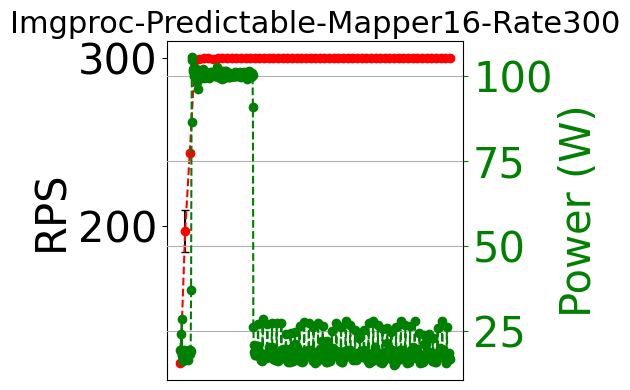

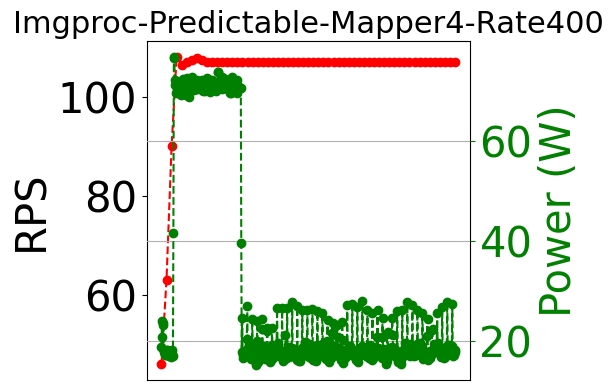

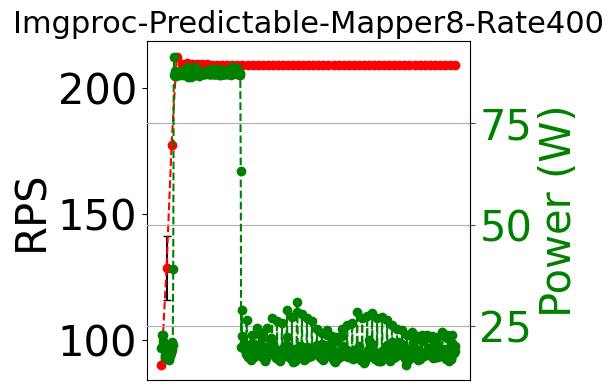

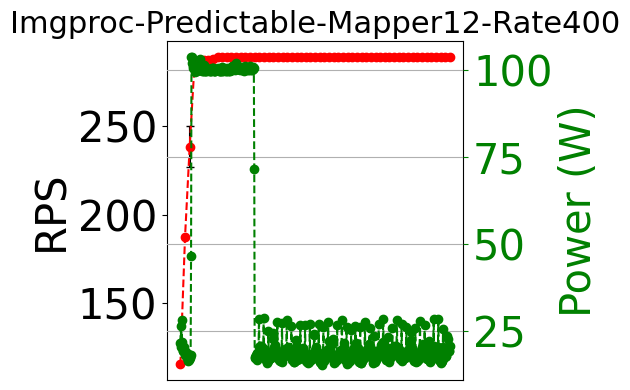

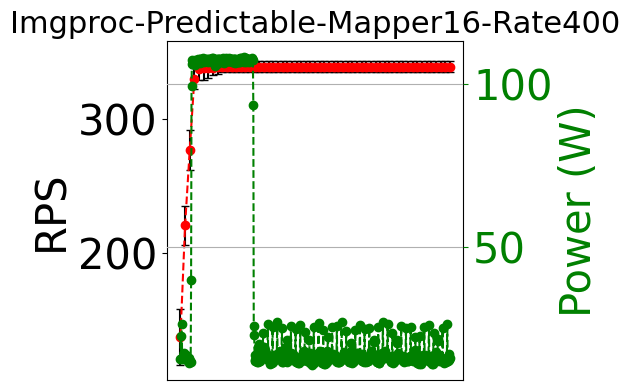

In [10]:
def parseLog(loc):
    ncores=16
    arr = []
    for i in range(0, ncores):
        arr.append([])
        srcf = f"{loc}/Flinklogs/Operator_Source: Bids Source_{i}"
        with open(srcf) as file:
            lines = [line.rstrip().split(';')[9] for line in file]
            for l in lines:
                if 'numRecordsOutPerSecond' in l:
                    jo = l[2:-1].replace("'", '"')
                    jo = json.loads(jo)
                    arr[i].append(float(jo['value']))
    minl = 9999
    for i in range(0, len(arr)):
        minl = min(minl, len(arr[i]))

    arrmean = []
    arrstd = []
    for i in range(0, minl):
        arrv = []
        for c in range(0, ncores):
            arrv.append(arr[c][i])
        arrmean.append(round(np.mean(arrv), 2))
        arrstd.append(round(np.std(arrv), 2))
    return arrmean, arrstd
            
combinations = list(itertools.product(policies, rates, times, mappers))

def parseRapl(loc):
    raplf = f"{loc}/rapl.log"
    with open(raplf) as file:
        lines = [float(line.rstrip().split(' ')[0]) for line in file]
    #print(lines)
    return lines

# Print the combinations
for combo in combinations:
    policy, rate, timems, mapper = combo
    loc=f"data/imgproc_cores16_frate{rate}_{timems}_fratetype_predictable_fbuff-1_itr{1}_{policy}dvfs{1}_source{16}_mapper{mapper}_sink{16}_repeat{0}"
    if not path.exists(loc+ "/rapl.log"):
        print("!!", loc+ "/rapl.log")
        break
    print(loc)

    plt.rcParams['figure.figsize'] = 6, 4
    plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=30)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=30)    # fontsize of the tick labels

    amean, astd = parseLog(loc)
    raplg = parseRapl(loc)
    
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)
    
    ax.errorbar(np.arange(len(amean)), amean, yerr=astd, capsize=3, fmt="r--o", ecolor = "black")
    ax.set_ylabel('RPS')
    ax.set_title(f"Imgproc-Predictable-Mapper{mapper}-Rate{rate}", size=22)
    ax.set_xticks([])

    ax2.errorbar(np.arange(len(raplg)-int(len(raplg)/10)), raplg[:len(raplg)-int(len(raplg)/10)], capsize=3, fmt="g--o", ecolor = "black")
    ax2.set_ylabel('Power (W)', color='g')
    #ax2.xaxis.tick_top()
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1") 
    #ax2.set_ylabel('y label 2', color="C1")       
    #ax2.xaxis.set_label_position('top') 
    ax2.tick_params(axis='y', colors="g")
    ax2.yaxis.set_label_position('right') 

    #ax2.set_title(f"Query1-Predictable-Mapper{mapper}-Rate{int(rate/1000)}K", size=22)
    ax2.set_xticks([])

    plt.grid()
    plt.tight_layout()
